In [1]:
import sys

import cv2
import numpy as np
from sklearn.cluster import KMeans

sys.path.append('../src')
from common import common, utils
from common.transform import Homography
from common.video import Capture


In [2]:
# file path
room_num = '08'
video_path = common.root + '/video_raw/08_05_Survey_20210915_070700_01.mp4'
field_path = common.data_dir + '{}/field.png'.format(room_num)
print(video_path)
print(field_path)

/tmp/sh076018/mishare/Research Projects/yokoyama/video_raw/08_05_Survey_20210915_070700_01.mp4
/tmp/sh076018/mishare/Research Projects/yokoyama/data/08/field.png


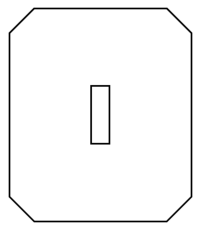

In [3]:
# open video and image
video = Capture(video_path)
frame = video.read()
utils.show_img(frame)

field = cv2.imread(field_path)
utils.show_img(field)

# ビデオ側の点を決定する
## ベッドを検出

In [16]:
hsv_range = {
    'min': np.array((0, 0, 50)),
    'max': np.array((180, 71, 81))
}
area = {
    'min': [490, 380],
    'max': [830, 600]
}

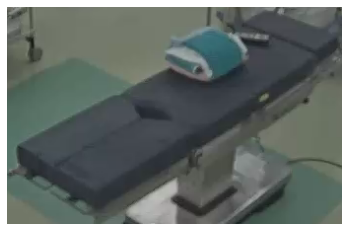

In [17]:
crop = frame[area['min'][1]:area['max'][1], area['min'][0]:area['max'][0]]
utils.show_img(crop)

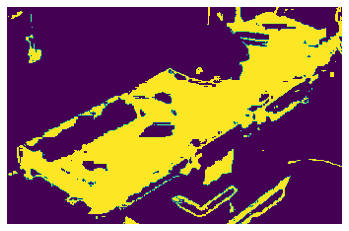

In [18]:
# rgb 2 hsv
hsv = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV)
hsv = cv2.inRange(hsv, hsv_range['min'], hsv_range['max'])
utils.show_img(hsv)

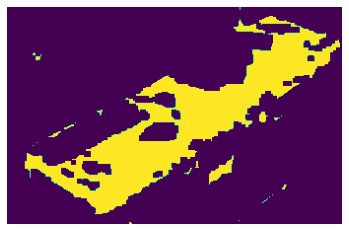

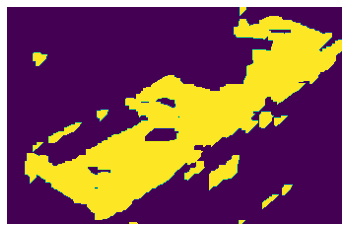

In [19]:
# noize reduction
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
erode = cv2.erode(hsv, kernel, iterations=4)
utils.show_img(erode)


kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2))
dilate = cv2.dilate(erode, kernel, iterations=6)
utils.show_img(dilate)

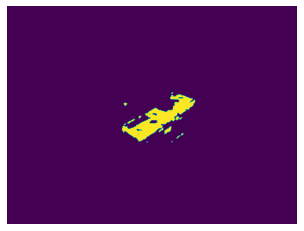

In [20]:
# create mask
mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
mask[area['min'][1]:area['max'][1], area['min'][0]:area['max'][0]] = dilate
utils.show_img(mask)

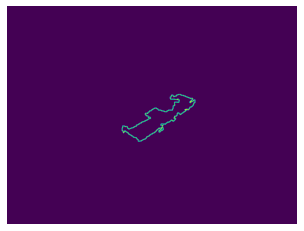

In [21]:
test = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)

# find contours
cnts, h = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# remove small area
cnts = list(filter(lambda x: cv2.contourArea(x) > 10000, cnts))

# draw
cv2.drawContours(test, cnts, -1, color=255, thickness=2)

utils.show_img(test)

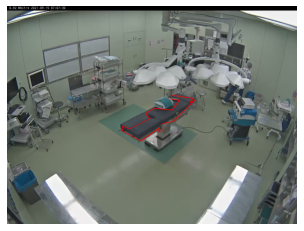

In [24]:
test = frame.copy()

cnt = cnts[0]
arclen = cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, arclen * 0.01, True)
approx = approx.reshape(-1, 2)

cv2.polylines(test, [approx], True, 255, thickness=2, lineType=cv2.LINE_8)
utils.show_img(test)

## 4点を決める

In [25]:
pred = KMeans(n_clusters=4).fit_predict(approx)
pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2, 2],
      dtype=int32)

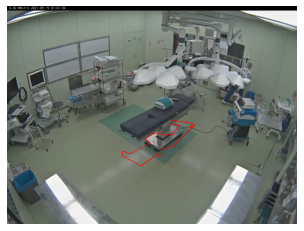

[[829 523]
 [808 535]
 [819 516]
 [726 502]
 [723 520]
 [760 524]
 [729 568]
 [650 560]
 [610 583]
 [632 605]
 [540 651]
 [510 638]
 [508 659]
 [591 704]
 [671 647]
 [670 664]
 [684 658]
 [681 629]
 [734 617]]


In [26]:
test = frame.copy()

y_length = 110
new_approx = approx.copy()
new_approx[:, 1] += y_length

cv2.polylines(test, [new_approx], True, 255, thickness=2, lineType=cv2.LINE_8)
utils.show_img(test)
print(new_approx)

In [27]:
x_min, y_min = np.min(new_approx, axis=0)
x_max, y_max = np.max(new_approx, axis=0)

In [28]:
[[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]

[[508, 502], [829, 502], [829, 704], [508, 704]]

# フィールド側の点を決定する

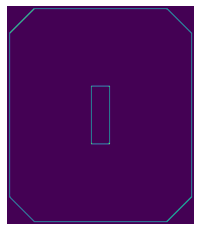

In [13]:
# rgb 2 gray
gray = cv2.cvtColor(field, cv2.COLOR_RGB2GRAY)
gray = cv2.bitwise_not(gray)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (4, 4))
gray = cv2.erode(gray, kernel, 1)
utils.show_img(gray)

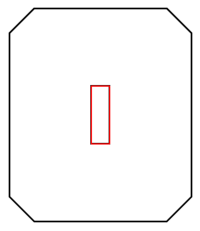

In [14]:
test = field.copy()

# find contours
lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi / 2, threshold=10, minLineLength=30, maxLineGap=0)

# draw
rect_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    length = np.linalg.norm((x1 - x2, y1 - y2))
    if length < 200:
        test = cv2.line(test, (x1, y1), (x2, y2), 255, 2)
        rect_lines.append(line[0])

utils.show_img(test)

In [15]:
rect_lines

[array([246, 331, 246, 192], dtype=int32),
 array([202, 331, 202, 192], dtype=int32),
 array([203, 331, 245, 331], dtype=int32),
 array([203, 192, 245, 192], dtype=int32)]

In [16]:
x_min, y_min = np.min(np.array(rect_lines).reshape(-1, 2), axis=0)
x_max, y_max = np.max(np.array(rect_lines).reshape(-1, 2), axis=0)

In [17]:
[[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]

[[202, 192], [246, 192], [246, 331], [202, 331]]

# 検証

In [1]:
import sys
import cv2

sys.path.append('../src')
from common import common, utils
from common.transform import Homography
from display import video
import cv2

/tmp/sh076018/mishare/Research Projects/yokoyama/video_raw/02_05_Survey_20210903_110000_01.mp4
/tmp/sh076018/mishare/Research Projects/yokoyama/data/02/field.png


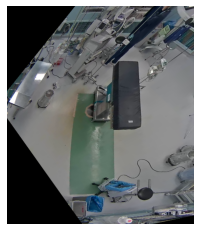

In [2]:
# file path
room_num = '02'
video_path = common.root + '/video_raw/02_05_Survey_20210903_110000_01.mp4'
field_path = common.data_dir + '{}/field.png'.format(room_num)
print(video_path)
print(field_path)

# open video and image
video = video.Capture(video_path)
frame = video.read()

field = cv2.imread(field_path)

p_video = transform.homo[room_num][0]
p_field = transform.homo[room_num][1]
homo = Homography(p_video, p_field, field.shape)
frame = homo.transform_image(frame)
utils.show_img(frame)